In [ ]:
#FRI JAN 7 TODO:
#TODO: Create symlinks in this directory for the dataset so that it can be exported to other people more easily
#TODO: Clean up the names of things in this notebook
#TODO: Create the moving shadow animations
#TODO: Move all these functions to other files and create a delegation notebook to test them
#TODO: Create the standard deviation measurement from multiple translations, and create a visualization for that deviation in this notebook (with some tests, of course)

## Imports and Setup

#### Imports

In [1]:
from rp import *
import torch
import einops
import icecream

#### Config

In [2]:
%config InlineBackend.figure_format='retina'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Helper Functions

In [3]:
def display_images(images):
    display_image(tiled_images(as_numpy_images(images)))

## Main Code

#### Prepare example data

rp.load_images: Done! Loaded 15 images in 0.018 seconds
A random cube model:


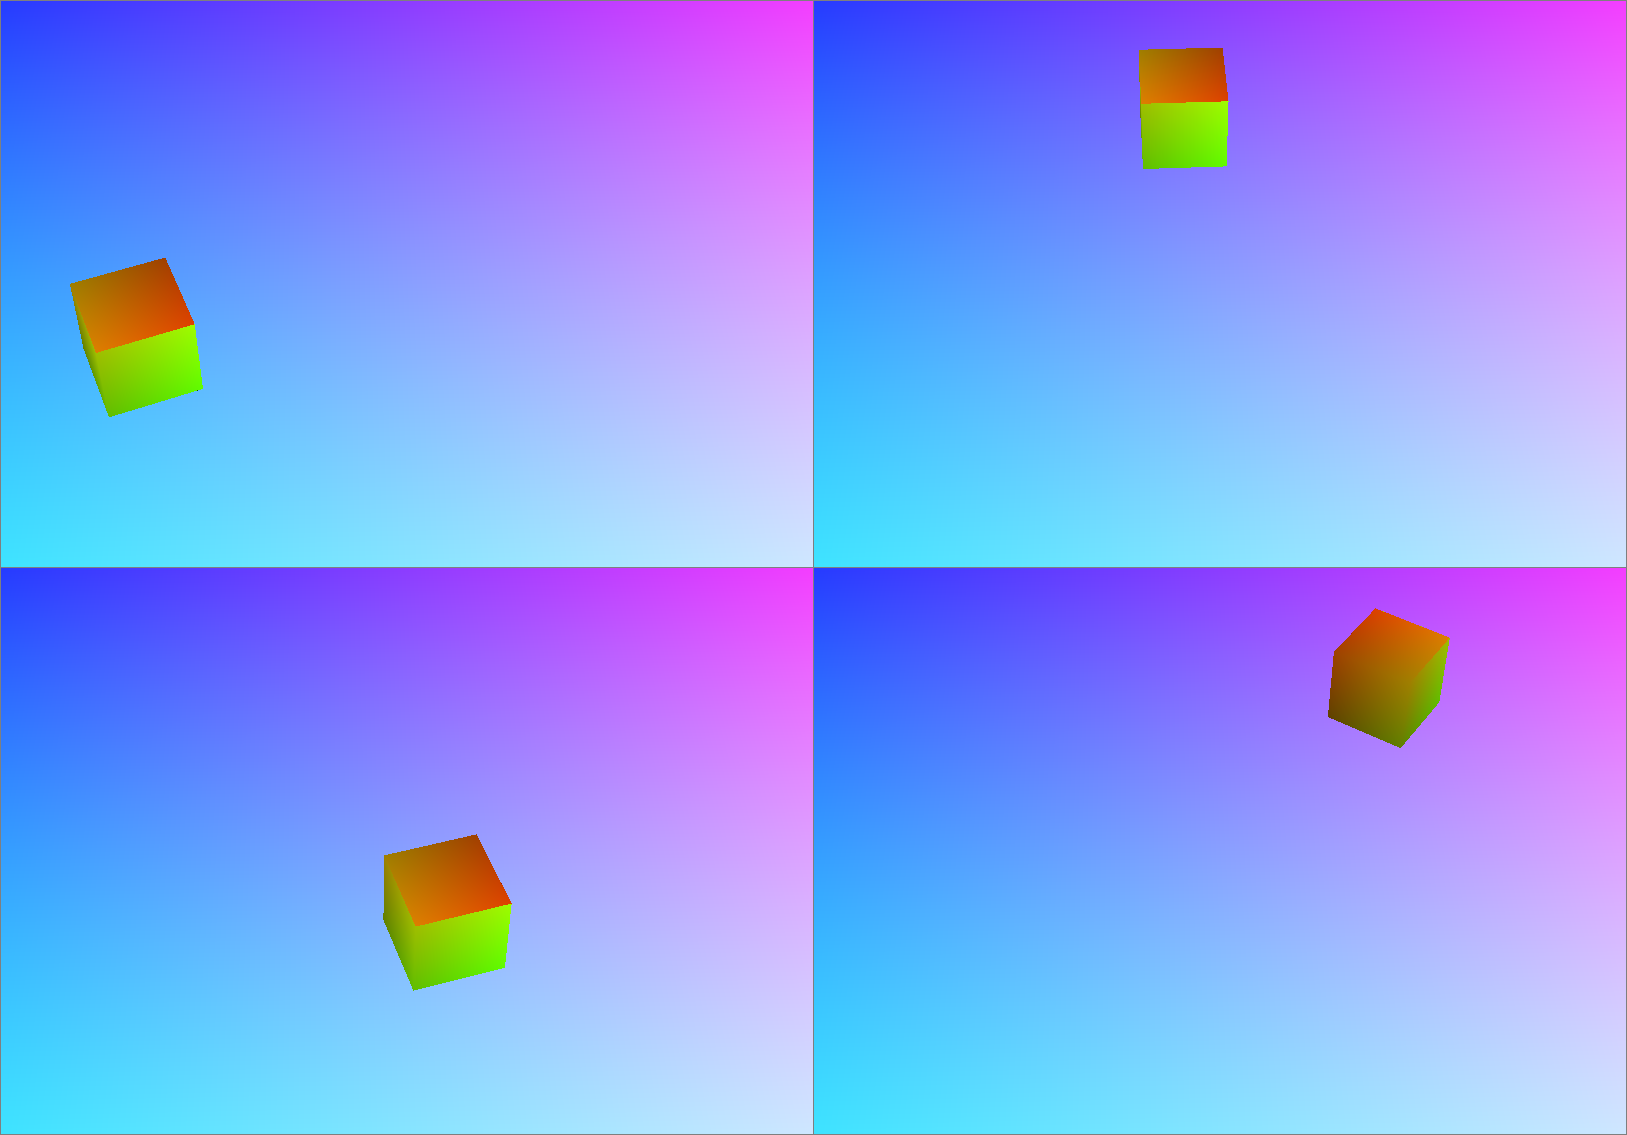

In [19]:
image_paths=get_all_files('/home/ryan/CleanCode/Datasets/diff_rendering/steve/UV_Cubes',sort_by='number')
image_paths=get_all_files('/home/ryan/CleanCode/Datasets/diff_rendering/alphabetcube_L/CroppedHalvedUV',sort_by='number')
image_paths=image_paths[:15] #For the previews, limit the number of samples. It makes the .ipynb files smaller.
cube_models=load_images(image_paths,show_progress=True,use_cache=True)
cube_models=[as_float_image(cube_model) for cube_model in cube_models]
cube_models=as_numpy_array(cube_models)
print("A random cube model:")
display_images(cube_models[:4])

Albedo Map:


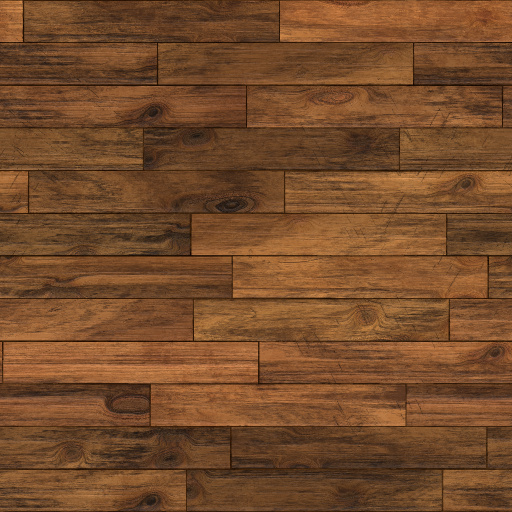

In [5]:
stone='https://www.filterforge.com/filters/12449.jpg'
tiles='https://filterforge.com/filters/10857-v4.jpg'
wood ='https://filterforge.com/filters/8892.jpg'
paved='https://filterforge.com/filters/14157.jpg'

albedo=wood

albedo=load_image(albedo,use_cache=True)
# albedo=resize_image(albedo,(256,256))
print("Albedo Map:")
display_image(albedo)

Second Albedo Map:


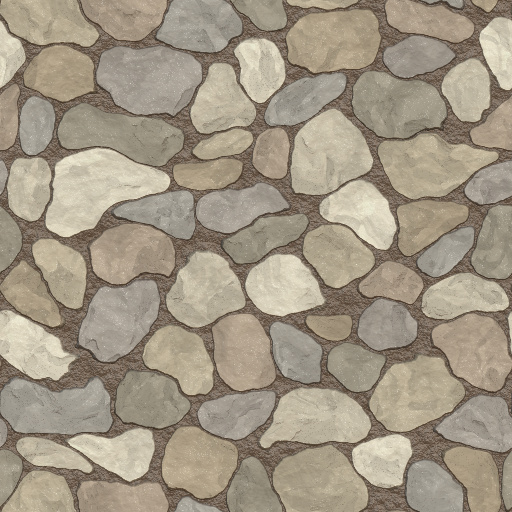

In [6]:
second_albedo=paved

second_albedo=load_image(second_albedo,use_cache=True)
print("Second Albedo Map:")
display_image(second_albedo)

In [7]:
torch_cube_models=as_torch_images(cube_models)

torch_albedo       =torch.tensor(albedo       ).permute(2,0,1)/255
torch_second_albedo=torch.tensor(second_albedo).permute(2,0,1)/255

#### Additional Functions

In [8]:
def condense_values(tensor,values):
    #Mutates the given tensor and returns it
    #   - tensor: can be either torch.Tensor or np.ndarray
    #   - values: should be a list of int
    #
    # EXAMPLES: Normal circumstances
    #     >>> condense_values(torch.Tensor([4,2,3,6,8,1]),[1,3,8])
    #    ans = tensor([4., 2., 1., 6., 2., 0.])
    #     >>> condense_values(torch.tensor([4,2,3,6,8,1]),[1,3,8])
    #    ans = tensor([4, 2, 1, 6, 2, 0])
    #     >>> condense_values(torch.tensor([4,2,3,6,8,1]),[1,2,3,4])
    #    ans = tensor([3, 1, 2, 6, 8, 0])
    #     >>> condense_values(torch.tensor([2,5,7,9]),[2,5,9])
    #    ans = tensor([0, 1, 7, 2])
    #     >>> condense_values(torch.tensor([2,5,7,9]),[2,5,7,9])
    #    ans = tensor([0, 1, 2, 3])
    #
    # EXAMPLES: When not all labels are covered
    #     >>> condense_values(torch.tensor([2,5,7,6]),[2,5,7,9])
    #    ans = tensor([0, 1, 2, 0])  # the last value is 0, because that's the default
    #
    # EXAMPLES: Works element-wise with arbitrary shapes
    #     >>> condense_values(torch.tensor([[2],[5],[7],[6]]),[2,5,7,9])
    #    ans = tensor([[0], [1], [2], [0]])
    #     >>> condense_values(torch.tensor([[2,5,7,6]]),[2,5,7,9])
    #    ans = tensor([[0, 1, 2, 0]])
    #
    # This function takes a 'tensor', and a list of numbers called 'values'
    # All elements in 'tensor' that are also in 'values' are simultaneously
    # replaced with their respective index in 'values'
    #
    # This function is used to let us specify which values of the b channel we're
    # using from the model images, so we can use multiple textures efficiently
    # See the uses of this function for a further understanding...

    values=sorted(values)
    for index,value in enumerate(values):
        tensor[tensor==value]=-index
    tensor[tensor>0]=0
    tensor=-tensor
    return tensor

In [9]:
def extract_scene_uvs_and_scene_labels_from_exr_scenes(scene_images:torch.Tensor, label_values:list):
    #Takes an image obtained from an .exr file (with R,G,B) and return two torch tensors
    #It assumes all values are between [0,1] and that B encodes the label value while 
    #R,G represent the U,V values respectively
    #It also assumes that there are a maximum of 256 possible labels
    #
    #label_values is a list of label values, that will be condensed into the range [0,len(label_values)-1]

    #------- Inputs Validation -------
    
    assert len(scene_images.shape)==4, 'Images should be in the form BCHW'
    
    
    #------- Outputs Calculation -------
    
    r=scene_images[:,0,:,:]
    g=scene_images[:,1,:,:]
    b=scene_images[:,2,:,:]
    
    scene_labels=torch.floor(b*256).clamp(min=0,max=255).long()
    scene_labels=condense_values(scene_labels,label_values)
    
    u,v=r,g
    scene_uvs=torch.stack((u,v),dim=1)
    
    
    #------- Outputs Validation -------
    
    batch_size, num_channels, scene_height, scene_width = scene_images.shape
    
    assert scene_uvs   .shape == (batch_size, 2, scene_height, scene_width)
    assert scene_labels.shape == (batch_size,    scene_height, scene_width)
    
    assert scene_labels.max()<len(label_values) and scene_labels.min()>=0
    assert not scene_labels.dtype.is_floating_point
    
    return scene_uvs, scene_labels

In [10]:
scene_uvs, scene_labels = extract_scene_uvs_and_scene_labels_from_exr_scenes(torch_cube_models,[0,255])

icecream.ic(torch_cube_models.shape,
            scene_uvs        .shape,
            scene_labels     .shape);

ic| torch_cube_models.shape: torch.Size([15, 4, 566, 812])
    scene_uvs        .shape: torch.Size([15, 2, 566, 812])
    scene_labels     .shape: torch.Size([15, 566, 812])


In [11]:
def colorized_scene_labels(scene_labels, label_colors):
    #Takes scene_labels, and turns each label into a certain color
    #This is useful for visualization, but might later be used for learning purposes as well
    #This is a pure function, as it does not mutate any of the inputs
    
    #------- Inputs Validation -------
    
    assert isinstance(scene_labels,torch.Tensor)
    assert isinstance(label_colors,torch.Tensor)
    
    batch_size, scene_height, scene_width = scene_labels.shape
    num_labels, num_channels              = label_colors.shape
    
    assert not scene_labels.dtype.is_floating_point
    assert     scene_labels.min()>=0 and scene_labels.max()<num_labels
    

    #------- Output Calculation -------
    
    output = einops.rearrange(scene_labels, 'BS SH SW -> (BS SH SW)')
    output = label_colors[output]
    output = einops.rearrange(output, '(BS SH SW) NC -> BS NC SH SW',
                              BS=batch_size                         ,
                              SH=scene_height                       ,
                              SW=scene_width                        )

    
    #------- Output Validation -------
    
    assert output.shape == (batch_size, num_channels, scene_height, scene_width)
    
    assert output.dtype == label_colors.dtype
    
    return output

Colorized with arbitrary colors, such as blue and pink...


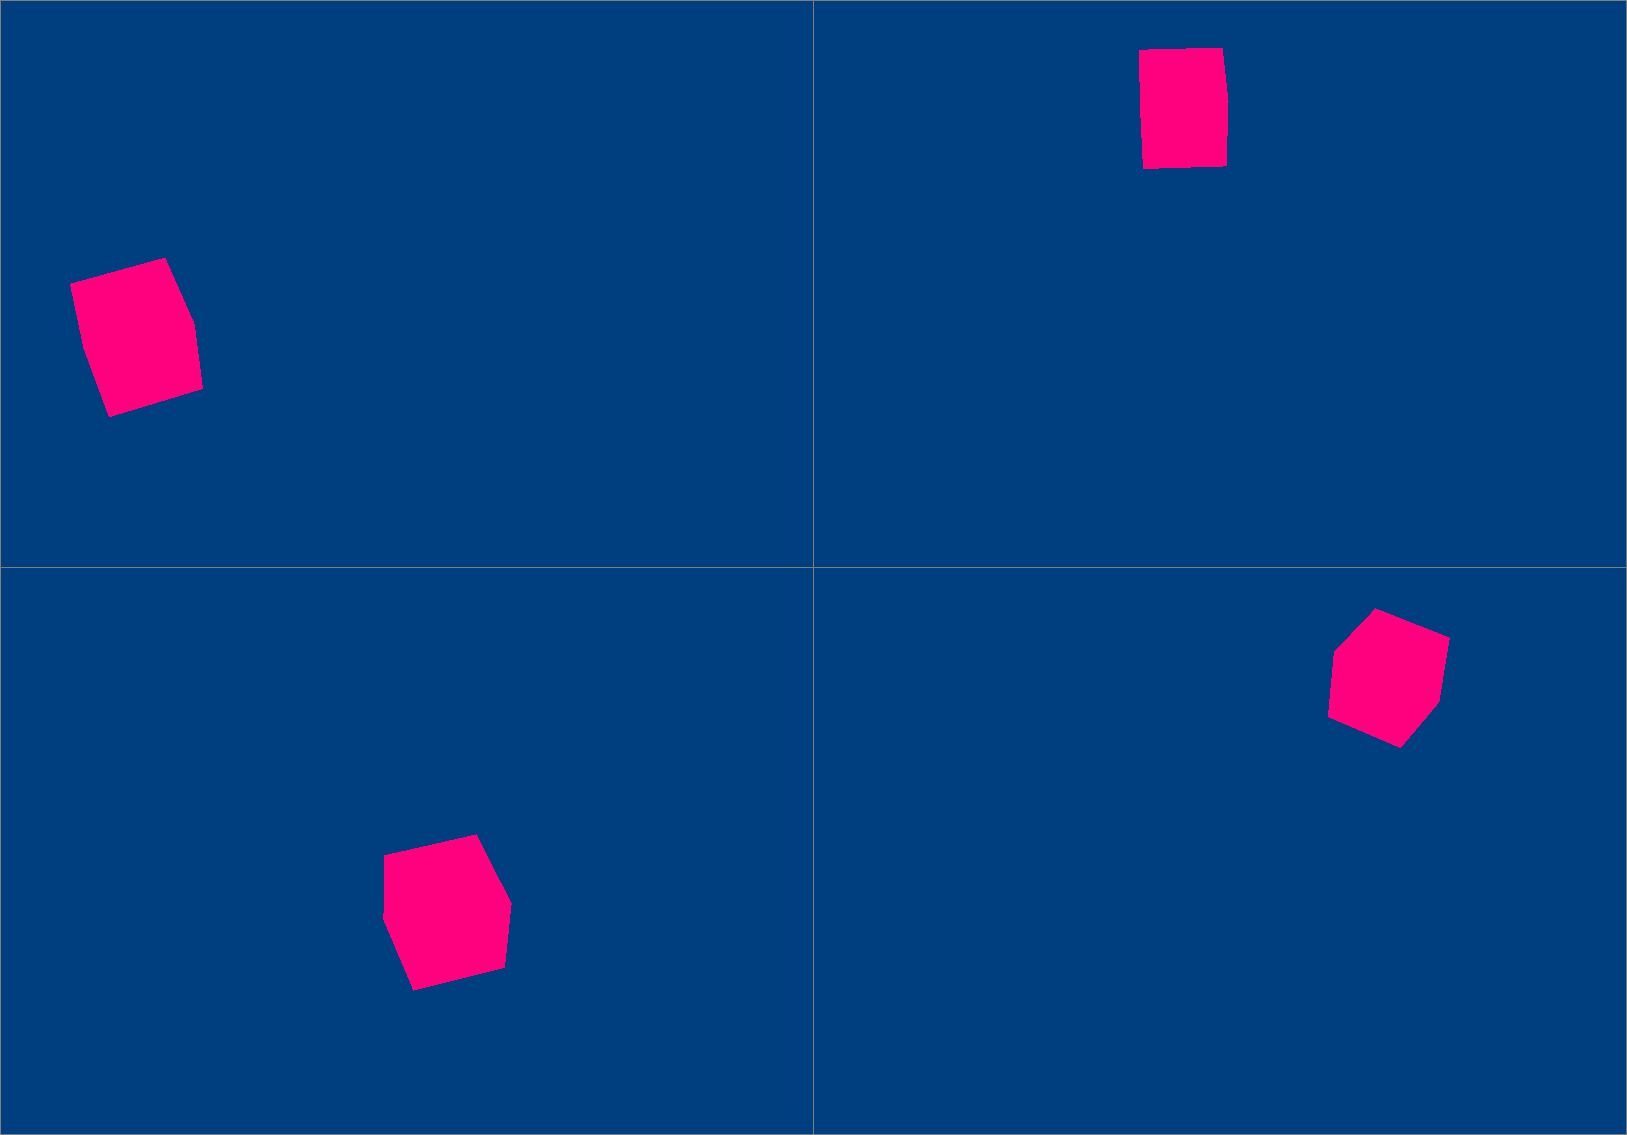

Colorized with more arbitrary colors, such as black and green...


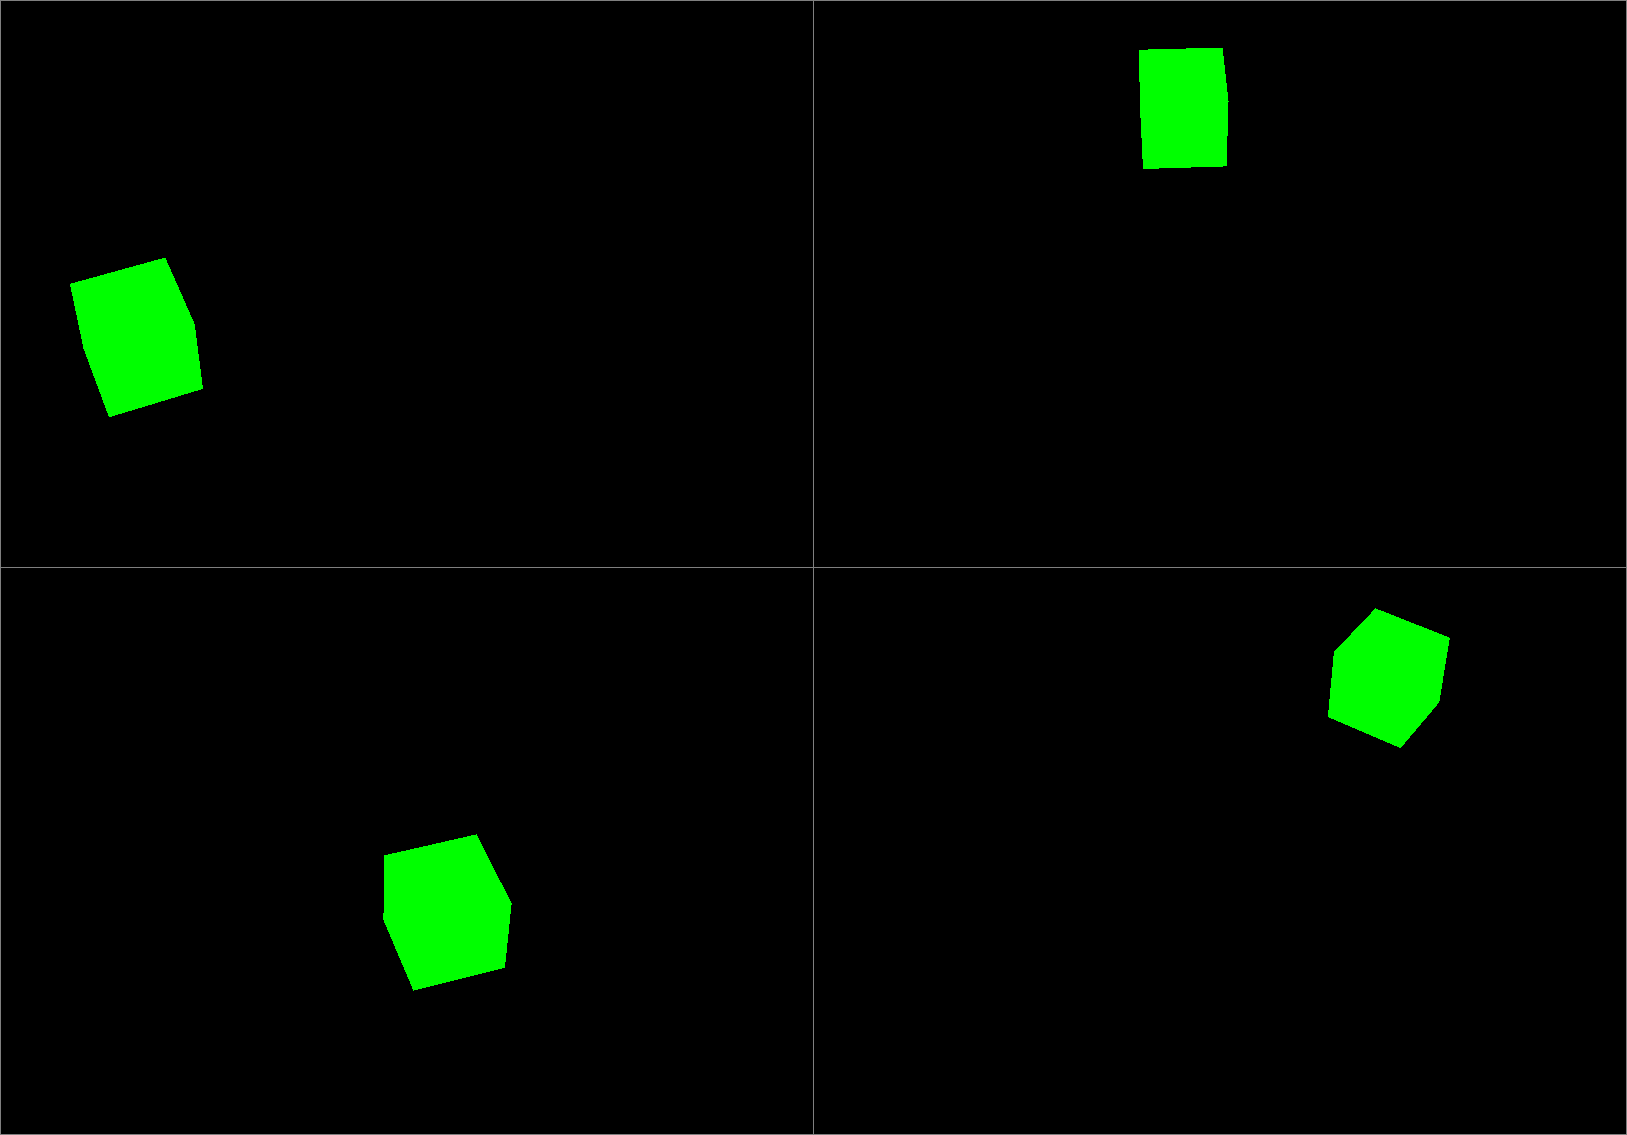

In [23]:
print("Colorized with arbitrary colors, such as blue and pink...")
colorized_labels = colorized_scene_labels(scene_labels, torch.Tensor([[1,0,.5],[0,.25,.5]]))
display_images(colorized_labels[:4])

print("Colorized with more arbitrary colors, such as black and green...")
colorized_labels = colorized_scene_labels(scene_labels, torch.Tensor([[0,1,0],[0,0,0]]))
display_images(colorized_labels[:4])

#### Projection

In [13]:
def project_textures(scene_uvs,scene_labels,textures):
    
    #TODO: Add linear interpolation like in unproject. This can be done.
    
    #------- Inputs Validation -------
    
    batch_size, scene_height, scene_width = scene_labels.shape
    assert not scene_labels.dtype.is_floating_point
    
    assert scene_uvs.shape == (batch_size, 2, scene_height, scene_width)
    
    num_labels, num_channels, texture_height, texture_width = textures.shape
    assert scene_labels.min()>=0 and scene_labels.max() < num_labels
    
    
    #------- Output Calculation -------
    
    u,v = einops.rearrange(scene_uvs, 'BS UV SH SW -> UV BS SH SW')
    u=torch.clamp(u*texture_height, min=0,max=texture_height-1).long()
    v=torch.clamp(v*texture_width , min=0,max=texture_width -1).long()
    
    assert u.shape == v.shape == (batch_size, scene_height, scene_width)
    
    textures     = einops.rearrange(textures, 'NL NC TH TW -> NL TH TW NC')
    
    scene_labels = einops.rearrange(scene_labels, 'BS SW SH -> (BS SW SH)')
    u            = einops.rearrange(u           , 'BS SW SH -> (BS SW SH)')
    v            = einops.rearrange(v           , 'BS SW SH -> (BS SW SH)')
                                    
    output = textures[scene_labels, u, v]
    output = einops.rearrange(output, '(BS SH SW) NC -> BS NC SH SW',
                              BS=batch_size                         ,
                              SH=scene_height                       ,
                              SW=scene_width                        )
    
    
    #------- Output Validation -------
    
    assert output.shape == (batch_size, num_channels, scene_height, scene_width)

    return output

torch.Size([2, 3, 512, 512])
Rendered images from torch: should look identical to the previous animation on every frame


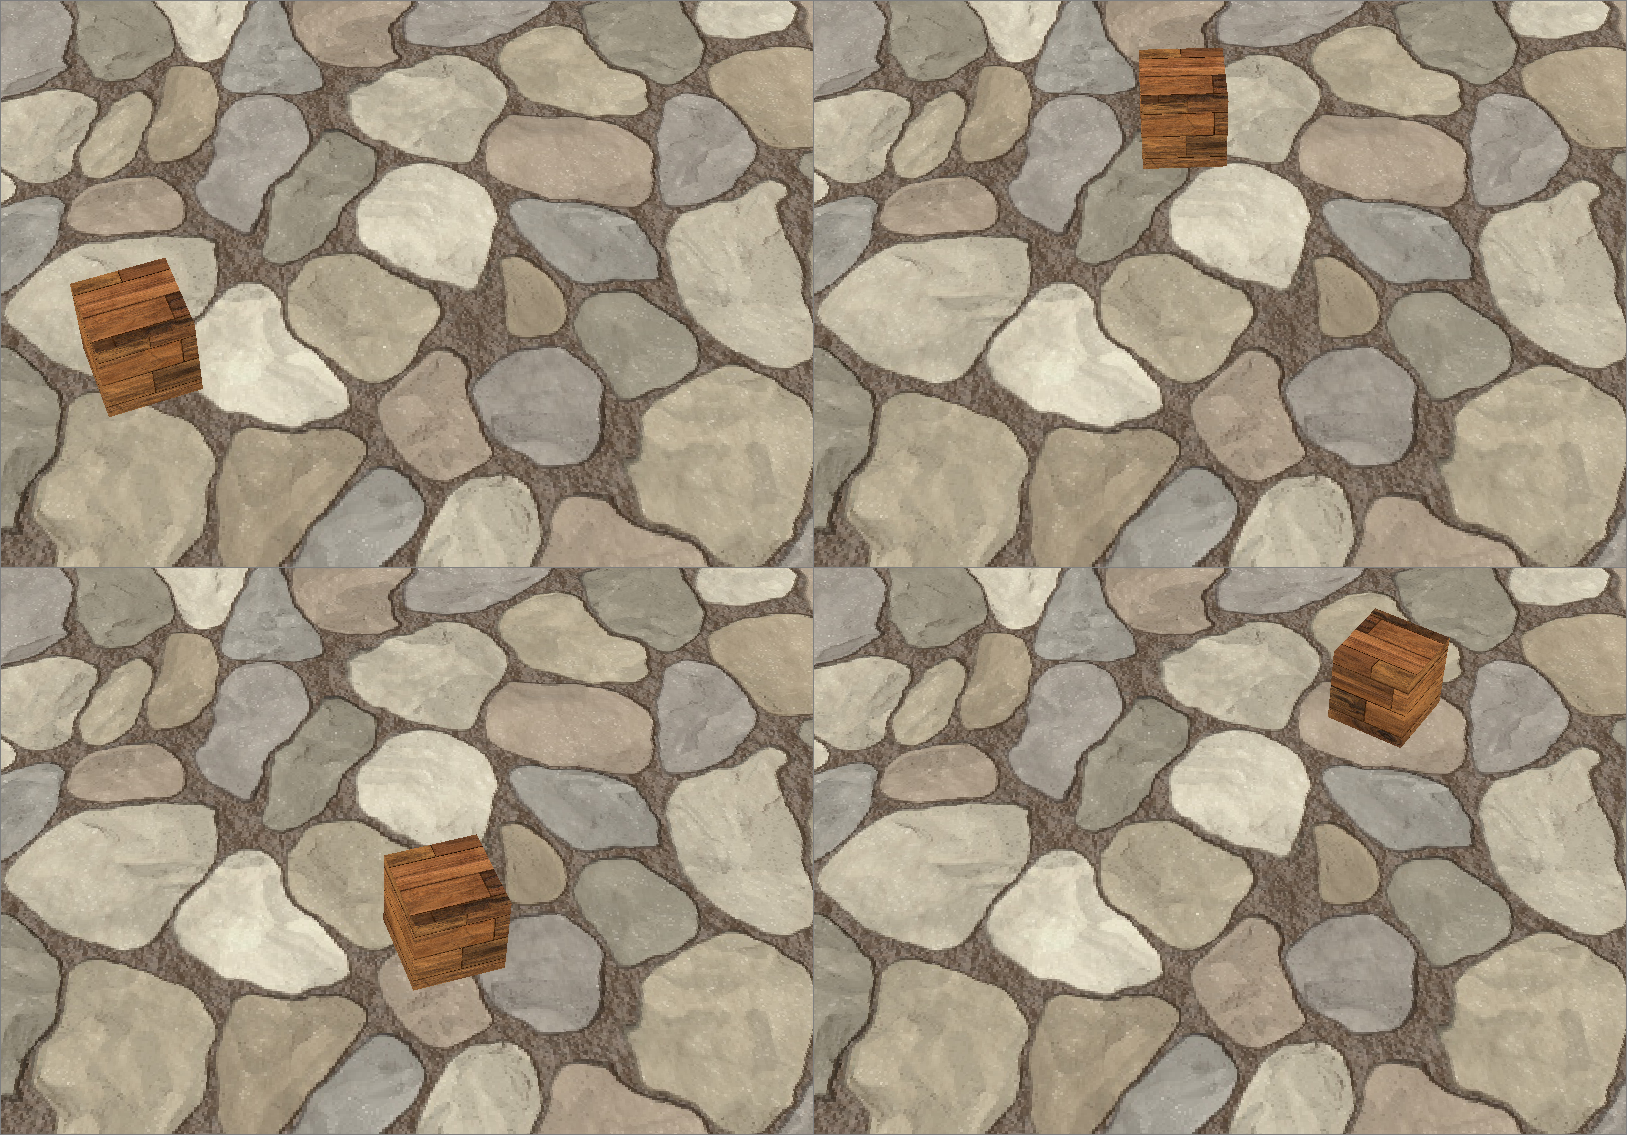

In [14]:
textures=torch.stack((torch_albedo, torch_second_albedo))

print(textures.shape)

scene_projections = project_textures(scene_uvs, scene_labels, textures)
print("Rendered images from torch: should look identical to the previous animation on every frame")
display_images(as_numpy_images(scene_projections[:4]))

#### Unprojection

In [15]:
def calculate_subpixel_weights(x,y):
    #This function's math is explained here: 
    #   https://www.desmos.com/calculator/esool5qrrd

    Rx=x%1
    Ry=y%1
    Qx=1-Rx
    Qy=1-Ry

    A=Rx*Ry #Weight for  ceil(x), ceil(y)
    B=Rx*Qy #Weight for  ceil(x),floor(y)
    C=Qx*Qy #Weight for floor(x),floor(x)
    D=Qx*Ry #Weight for floor(x), ceil(y)

    Cx=x.ceil ().long()
    Cy=y.ceil ().long()
    Fx=x.floor().long()
    Fy=y.floor().long()

    X=torch.stack((Cx,Cx,Fx,Fx)) #All X values
    Y=torch.stack((Cy,Fy,Fy,Cy)) #All Y values
    W=torch.stack((A ,B ,C ,D )) #Weights

    return X,Y,W

In [16]:
def unproject_translations(scene_uvs          : torch.Tensor ,
                           scene_labels       : torch.Tensor ,
                           scene_translations : torch.Tensor ,
                           num_labels         : int          ,
                           output_height      : int          ,
                           output_width       : int          ,
                           version            : str='fast'   ):
    #This function is the opposite of the project_textures function
    #It's an inverse function, in a way
    #See the unproject_translations_demo.ipynb for a visual example
    #
    #This is a pure function: it doesn't mutate any of the input tensors
    #It outputs two torch.Tensor values, one of which is the mean and the other is weights

    #Ryan's personal notes:
    # TODO: Possibly change all things called 'output' to 'texture' to make it consistent naming with other functions
    # TODO: Come up with a better name for this function
    # MAYBE todo: eliminate batch size, because we're going to be doing this once for every image anyway...
    # Batch size is technically unnesecary...but it might be nice to keep it, idk...it combines confidence of multiple scenes very nicely...(ok, I'll keep batch size)
    # TODO: Perhaps keep track of output_sum_of_squares as well (another vector) so that we could output the variance at the same time as we output the sum?
    # The alternative is running this funtion multiple times, and comparing the texture outputs...which is also a totally valid approach. It doesn't need BS to do that though...

    #------- Input Validation -------
    
    #Validate scene_uvs
    batch_size, two, scene_height, scene_width = scene_uvs.shape
    assert two == 2, "scene_uvs should have exactly two channels"
    assert scene_uvs.min() >= 0 and scene_uvs.max() <=1, 'All u,v values should be between 0 and 1'

    #Validate scene_labels
    assert     scene_labels.shape == (batch_size, scene_height, scene_width)
    assert     scene_labels.max() < num_labels     , "The scene_labels includes labels that can't be included in the output!"
    assert not scene_labels.dtype.is_floating_point, "scene_labels should be an integer type, because it is used as an index"

    #Validate scene_translations
    num_channels = scene_translations.shape[1]
    assert scene_translations.shape == (batch_size, num_channels, scene_height, scene_width)

    #Validate integer arguments
    assert num_labels    >= 1 and isinstance(num_labels   ,int)
    assert output_height >= 1 and isinstance(output_height,int)
    assert output_width  >= 1 and isinstance(output_width ,int)

    #Validate version
    assert version in ['fast','slow']


    #------- Outputs Calculation -------

    #This 'Outputs Calculation' section is acronym-heavy.
    #Acronym Key:
    #  - BS = batch_size
    #  - SH,SW,OH,OW = scene_height,scene_width,output_height,output_width
    #  - NC,NL = num_channels,num_labels
    #  - ABCD = 4: it refers to the four A,B,C,D values in the function calculate_subpixel_weights
    #  - w = weights
    #  - t = weighted scene_translations, which are summed together to get the output
    NC = num_channels
    NL = num_labels
    OH = output_height
    OW = output_width

    #Populate the outputs
    u,v = einops.rearrange(scene_uvs.clone(),'BS NC SH SW -> NC BS SH SW')
    assert u.shape == v.shape == (batch_size, scene_height, scene_width)
    
    #Convert u,v from range [0,1),[0,1) to [0,output_height),[0,output_width)
    u *= output_height#-1
    v *= output_width #-1 To subtract 1 or not...depends on the projection function, and whether not u=.999999 means a bottom pixel

    #Calculate the subpixel weights w, and make u,v integers
    u,v,w = calculate_subpixel_weights(u,v)
    assert u.shape == v.shape == w.shape == (4, batch_size, scene_height, scene_width)
    assert not u.dtype.is_floating_point and not v.dtype.is_floating_point

    #The calculate_subpixel_weights is likely to reference indices one index outside of the image.
    #Correct this by pushing those indices back into the image again.
    u=u.clamp(0,output_height-1)
    v=v.clamp(0,output_width -1)
    l = scene_labels

    t = scene_translations

    #Reshape stuff
    u = einops.rearrange(u, 'ABCD BS    SH SW -> (BS SH SW ABCD)   '       )
    v = einops.rearrange(v, 'ABCD BS    SH SW -> (BS SH SW ABCD)   '       )
    w = einops.rearrange(w, 'ABCD BS    SH SW -> (BS SH SW ABCD)   '       )
    l = einops.repeat   (l, '     BS    SH SW -> (BS SH SW ABCD)   ',ABCD=4)
    t = einops.repeat   (t, '     BS NC SH SW -> (BS SH SW ABCD) NC',ABCD=4)

    #Create empty output tensors
    output_device = scene_translations.device
    output_weight = torch.zeros((num_labels, output_height, output_width              ), device = output_device)
    output_sum    = torch.zeros((num_labels, output_height, output_width, num_channels), device = output_device)

    assert len(t) == len(u) == len(v) == len(w) == len(l)

    if version=='fast':
        #THE FAST VERSION:
        #This version is very fast, but a bit cryptic
        #
        #Summary of this version using imprecise notation:        
        #  #What I'd like to write, but can't:
        #     output_sum   [l, u, v] += t 
        #     output_weight[l, u, v] += w 
        #     # This doesn't accumulate properly when we have duplicate l,u,v's
        #  #Splitting it into R,G,B:
        #     output_sum   [l, u, v, 0] += t[:,0] 
        #     output_sum   [l, u, v, 1] += t[:,1] 
        #     output_sum   [l, u, v, 2] += t[:,2] 
        #     output_weight[l, u, v] += w 

        output_sum    = output_sum   .view(NL*OH*OW*NC)
        output_weight = output_weight.view(NL*OH*OW   )

        for i in range(NC):
            output_sum.index_add_(0, (l*OH*OW*NC + u*OW*NC + v*NC + i), t[:,i]*w)
        output_weight.index_add_ (0, (l*OH*OW    + u*OW    + v       ),        w)
        
        output_sum    = output_sum   .view(NL,OH,OW,NC)
        output_weight = output_weight.view(NL,OH,OW   )

    if version=='slow':
        #THE SUPER-SLOW VERSION:    
        # This version is very slow, but much easier to understand. 
        # It gives exactly the same results as when version=='fast'
        # This version was used to verify the correctness of the 'fast' version
        # In my experiments, version=='slow' took 181 seconds whereas 'fast' took 0.003057 seconds. That's a 59208x speedup!
        # Note: the first call of the 'fast' version often takes longer than subsequent calls; going from .1 seconds to .003
        for l_,u_,v_,t_,w_ in zip(l,u,v,t,w):
            output_sum   [l_,u_,v_]+=w_*t_
            output_weight[l_,u_,v_]+=w_
        
    output_sum = einops.rearrange(output_sum, 'NL OH OW NC -> NL NC OH OW')
    assert output_sum.shape == (num_labels, num_channels, output_height, output_width)
    
    denominator = output_weight.clone()
    denominator[denominator == 0] = 1  # Avoid division by zero errors
    denominator = denominator[:, None, :, :]  # Make this tensor fit

    output_mean = output_sum/denominator


    #------- Outputs Validation -------

    assert output_mean  .shape == (num_labels, num_channels, output_height, output_width)
    assert output_weight.shape == (num_labels,               output_height, output_width)
    
    return output_mean, output_weight

In [17]:
num_labels=len(textures)
recovery_resolution=1024
# recovery_resolution=512
# recovery_resolution=256
recovered_textures, _ = unproject_translations(scene_uvs,
                                               scene_labels,
                                               scene_projections,
                                               num_labels,
                                               output_height=recovery_resolution,
                                               output_width=recovery_resolution)

Unprojection mean:


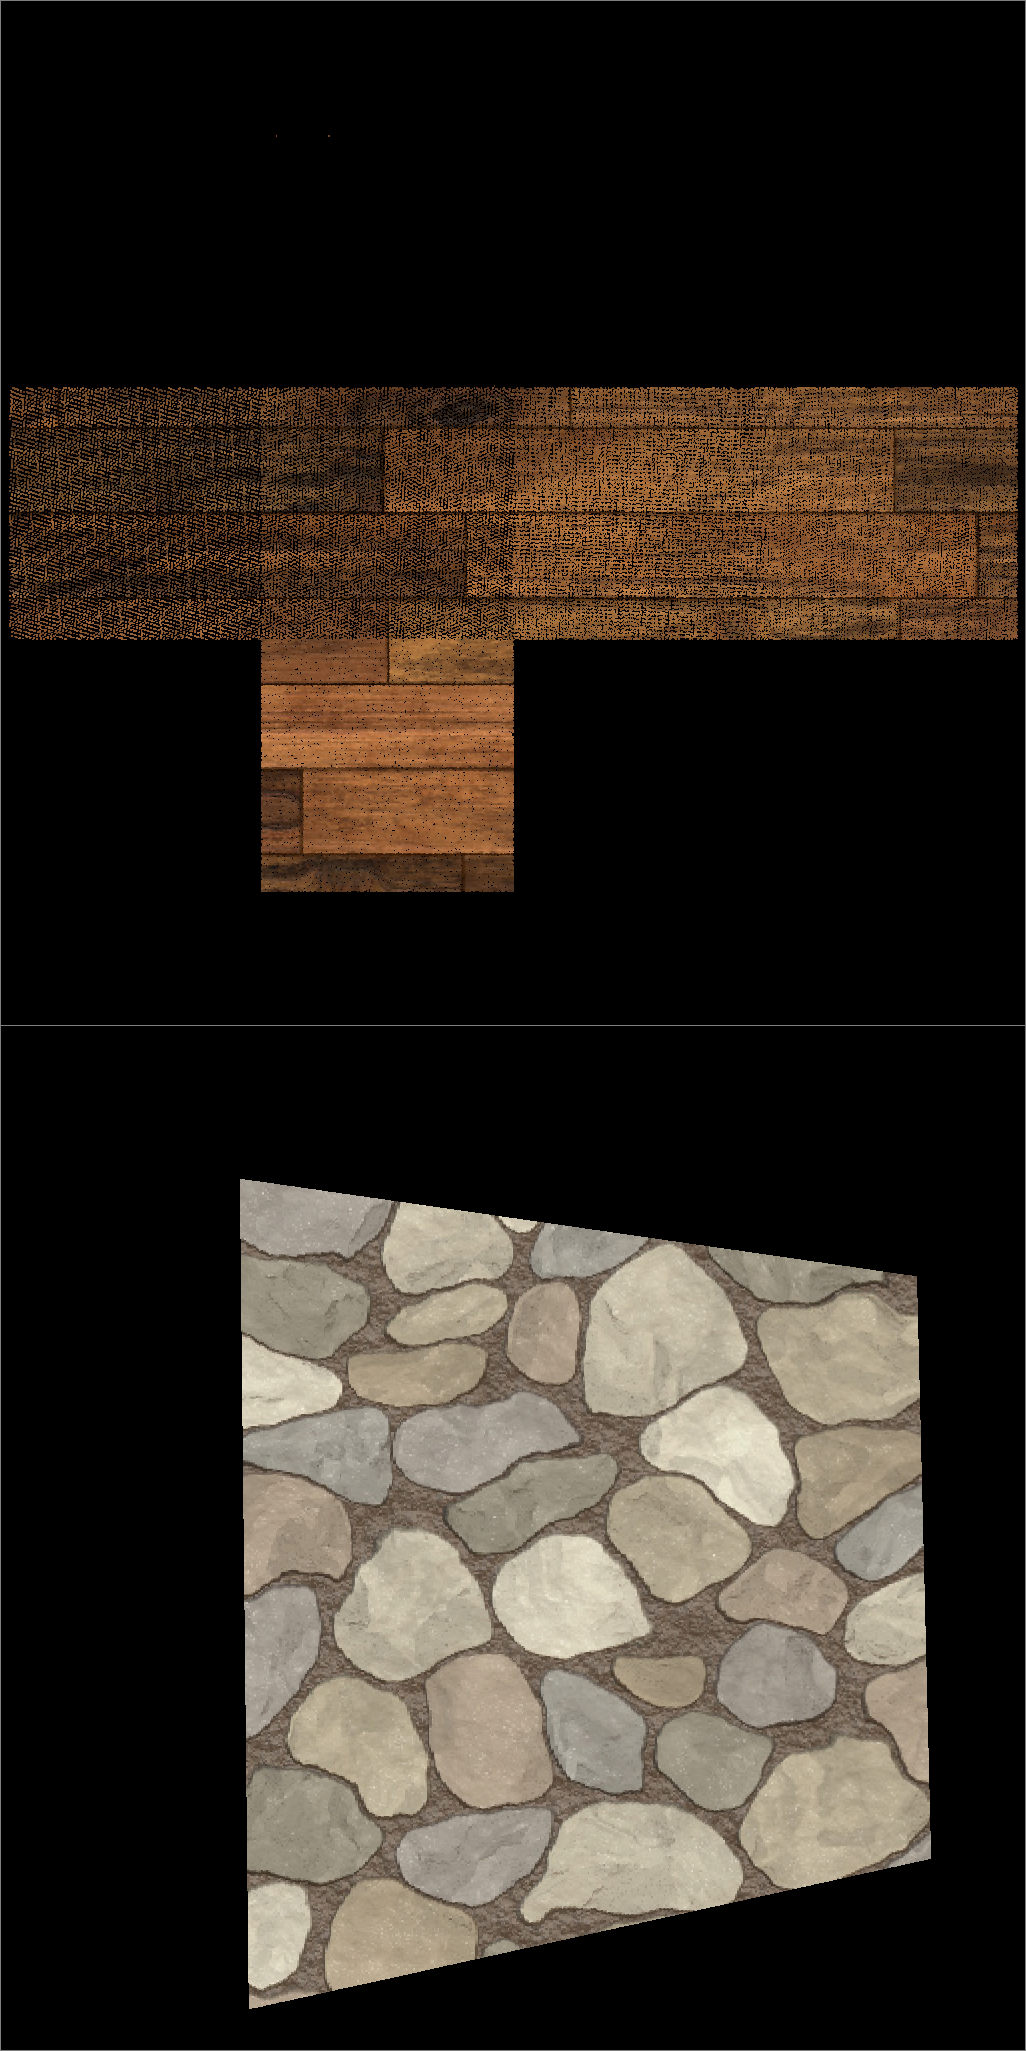

Unprojection weights:


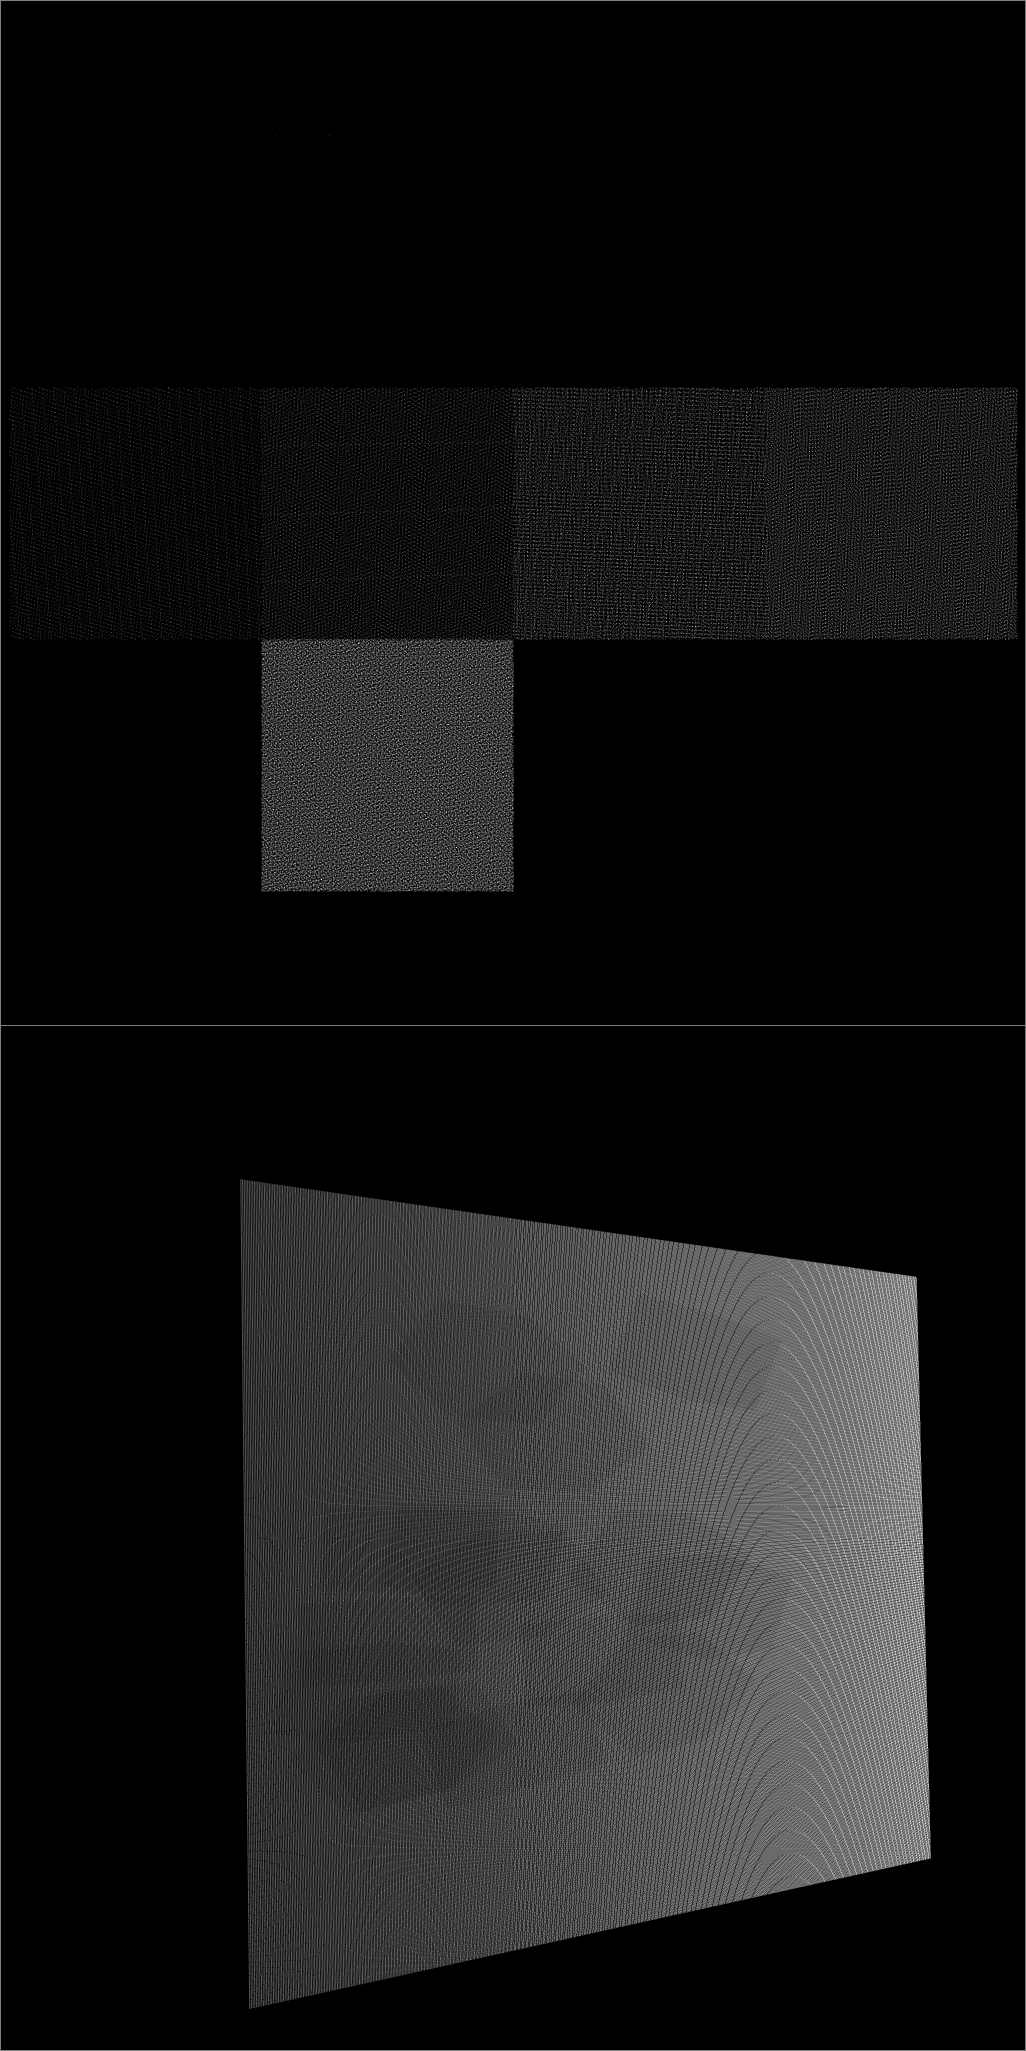

In [18]:
print("Unprojection mean:")
display_images(recovered_textures)
w=torch.stack((_,_,_),dim=1)
w=w/w.max(dim=1,keepdim=True)[0].max(dim=2,keepdim=True)[0].max(dim=3,keepdim=True)[0]
print("Unprojection weights:")
display_images(w)